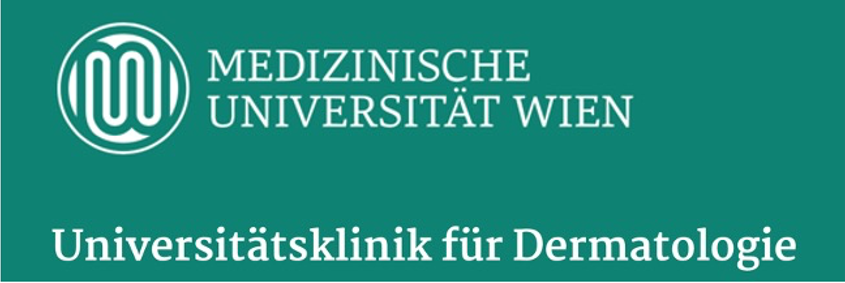

# <p style="text-align: center;"> R statistical programming for data analysis of next generation sequencing based gene expression analysis </p>

## <p style="text-align: center;"> chapter 7 </p>

## in this notebook we will analyse a 10x reference dataset
>* Human peripheral blood mononuclear cells (PBMCs) of a healthy female donor aged 25-30 were obtained by 10x Genomics from AllCells.   
>* Libraries were generated from ~16,000 cells (11,996 cells recovered) as described in the Chromium Next GEM Single Cell 3' HT Reagent Kits v3.1 User Guide (CG000416 Rev A) using the Chromium X and sequenced on an Illumina NovaSeq 6000 to a read depth of approximately 40,000 mean reads per cell. 
>* similar datasets are available [here](https://www.10xgenomics.com/resources/datasets?query=&page=1&configure%5Bfacets%5D%5B0%5D=chemistryVersionAndThroughput&configure%5Bfacets%5D%5B1%5D=pipeline.version&configure%5BhitsPerPage%5D=500)

In [2]:
rm(list=ls())  
my.libs=c("Seurat","scran","scater","DropletUtils","tidyverse","limma","Matrix","ggtree","cowplot")
lapply(my.libs, require, character.only = TRUE)
sessionInfo()

Loading required package: Seurat

Loading required package: scran

Loading required package: BiocParallel

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, ma

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/python/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] cowplot_1.0.0               ggtree_1.12.7              
 [3] Matrix_1.2-14               limma_3.38.3               
 [5] forcats_0.5.0               stringr_1.4.0              
 [7] dplyr_1.0.5                 purrr_0.3.4                
 [9] readr_1.3.1                 tidyr_1.0.2      

## 1. import data  
>* import the raw count data (raw_feature_bc_matrix)  
>* run emptydrops (or just use filtered output from cellranger6)  

In [10]:
### I like to create small summary files about the QC process:
sample_ID=c("10xPBMCs")
out=c("/fast/LV_exploratory/home/mwielscher/chapter_7/")  ## you can set a seperate directory for output
## make a QC-overview file
metrics=c("input_file","background_FDR","cells", "mitochRNA_thresh","mitochRNA_excl",
          "doublets","cells_post_QC","genes_post_QC","umi_per_gene","genes_per_cell","UMI_per_cell","UMIs_in_top50_in_perc","HVG_thresh_type","HVG_thresh",
         "HVG","PCs","PCs_assocTECH","resolution","cluster","diffGenes_total")
overview=data.frame(metric=rep(NA,length(metrics)),sample=rep(NA,length(metrics)))
colnames(overview)[2]=c(sample_ID)
row.names(overview)=overview$metric=as.character(metrics)
inputfile=c("input_PBMC_10K_10x_refDATA_nov2020.RData")
load(paste0(inputfile))
overview["input_file",2]=as.character(inputfile)
overview

,metric,10xPBMCs
,<chr>,<chr>
input_file,input_file,input_PBMC_10K_10x_refDATA_nov2020.RData
background_FDR,background_FDR,NA
cells,cells,NA
mitochRNA_thresh,mitochRNA_thresh,NA
mitochRNA_excl,mitochRNA_excl,NA
doublets,doublets,NA
cells_post_QC,cells_post_QC,NA
genes_post_QC,genes_post_QC,NA
umi_per_gene,umi_per_gene,NA


### exclude empty droplets:  
[empty Drops method](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1662-y) for distinguishing between background (droplets with no RNA) from droplets containing RNA based on modeling the background of empty drops and compare them to drops with RNA  
lower is a stat parameter to model ambient RNA and cannot be directly translated to number of UMIs 

In [8]:
empty_thresh=c(0.05)
overview["background_FDR",2]=empty_thresh
dat1=DropletUtils::emptyDrops(dat, lower=400, retain=NULL)   ## very slow !!
dat1$FDR[is.na(dat1$FDR)]=1
paste(table(dat1$FDR <empty_thresh)[2],"droplets are below FDR < 0.05 for not being background noise",sep=" ")
overview["cells",2]=table(dat1$FDR <empty_thresh)[2]
dat=dat[,dat1$FDR < empty_thresh]  
rm(dat1) 

[1] "11037 droplets are below FDR < 0.05 for not being background noise"

### mitochondiral RNA

Warning message in plot.histogram(r, freq = freq1, col = col, border = border, angle = angle, :
“the AREAS in the plot are wrong -- rather use 'freq = FALSE'”
Warning message in plot.histogram(r, freq = freq1, col = col, border = border, angle = angle, :
“the AREAS in the plot are wrong -- rather use 'freq = FALSE'”


png 
  2


FALSE  TRUE 
  911 10126 

[1] 36601 10222

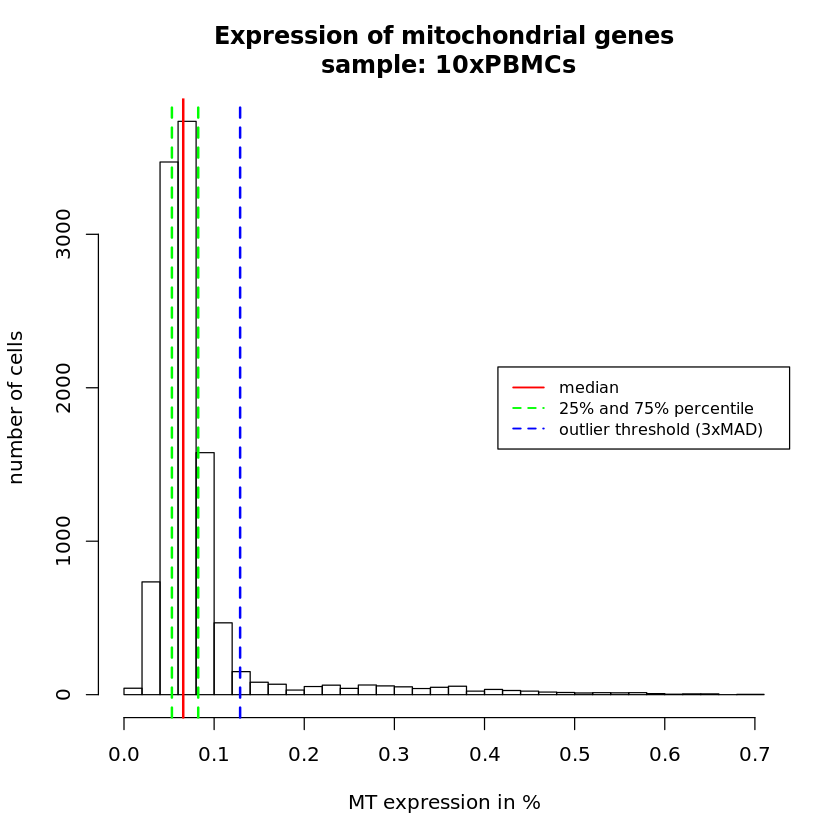

In [11]:
sce = SingleCellExperiment(assays = list(counts = as.matrix(dat)))
is.mito=grepl("MT-",rownames(assay(sce)))
perc_mt=apply(assay(sce),2,function(x) sum(x[is.mito]/sum(x)))
a=c(seq(0,1,by=0.02)[1:length(seq(0,max(perc_mt),by=0.02))-1],max(perc_mt))
hist(perc_mt,breaks=a,freq=T,main=paste("Expression of mitochondrial genes\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("MT expression in %"))
abline(v=median(perc_mt),col="red",lwd=2)
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
abline(v=(median(perc_mt)+3*(mad(perc_mt))),col="blue",lty=2,lwd=2)
legend("right", legend=c("median", "25% and 75% percentile","outlier threshold (3xMAD)"),
       col=c("red", "green","blue"), lty=c(1,2,2),lwd=1.5, cex=0.8)
              
#######.   ------------------------------------
jpeg(paste0(out,sample_ID,"_mtRNA.jpeg"))
hist(perc_mt,breaks=a,freq=T,main=paste("Expression of mitochondrial genes\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("MT expression in %"))
abline(v=median(perc_mt),col="red",lwd=2)
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
abline(v=(median(perc_mt)+3*(mad(perc_mt))),col="blue",lty=2,lwd=2)
legend("right", legend=c("median", "25% and 75% percentile","outlier threshold (3xMAD)"),
       col=c("red", "green","blue"), lty=c(1,2,2),lwd=1.5, cex=0.8)
              
dev.off()             
              
## ------------     check and subset
table(perc_mt < (median(perc_mt)+3*(mad(perc_mt))))
thresh=median(perc_mt)+3*(mad(perc_mt))
thresh=0.15
exclude_mtDNA=table(perc_mt < thresh)[1]            
sce1=sce[,perc_mt < thresh]
overview["mitochRNA_thresh",2]=thresh
overview["mitochRNA_excl",2]=exclude_mtDNA
dim(sce1)

### remove Doublets 

[Doublet cells](https://ltla.github.io/SingleCellThoughts/software/doublet_detection/bycell.html) for each cell are simultated and compared to the actual neighboing cells of the tested cell (this makes a score)
* Force match corrects for RNA content of cells  
* size factors and normalization is computed internally to avoid confusion  
* This is what happens:  
> 1. Simulate thousands of doublets by adding together two single-cell profiles.  
> 2. For each original cell, compute the density of simulated doublets in the surrounding neighbourhood.  
> 3. For each original cell, compute the density of other observed cells in the neighbourhood.  
> 4. Return the ratio between the two densities as a “doublet score” for each cell.  


__cutoff should be around 4__

In [14]:
table(doub_score>thresh)


FALSE 
10222 

[1] "in sample QC process we excluded 815 samples due to hight Mitochondrial DNA proportion and 10222 potential Doublet cells"

[1] "that leaves  10222 cells for further analysis"

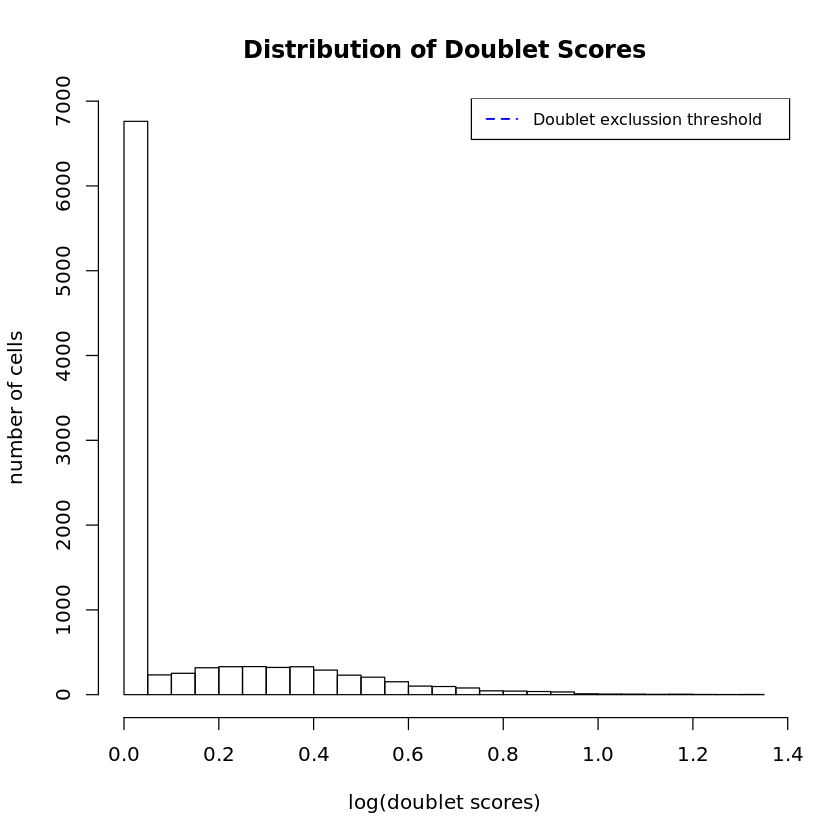

In [13]:
doublet_score=scran::doubletCells(sce1, k = 200,force.match=TRUE)
doub_score=log10(doublet_score+1)
thresh=median(doub_score)+3*mad(doub_score)
thresh=4
hist(doub_score,breaks=25,main="Distribution of Doublet Scores",xlab="log(doublet scores)",ylab=c("number of cells"))
abline(v=thresh,col="blue",lty=2,lwd=2)
legend("topright", legend=c("Doublet exclussion threshold"),
       col=c("blue"), lty=c(2),lwd=1.5, cex=0.8)

exclude_doublet=table(doub_score>thresh)[1]
sce2=sce1[,doub_score<thresh]
paste("in sample QC process we excluded",exclude_mtDNA,"samples due to hight Mitochondrial DNA proportion and",
      exclude_doublet,"potential Doublet cells",sep=" ")
paste("that leaves ", dim(sce2)[2], "cells for further analysis")
overview["doublets",2]=exclude_doublet

### UMI per cell (library size)

In [15]:
umi_per_cell=apply(assay(sce1),2,sum)
median(umi_per_cell)

[1] 9139

png 
  2

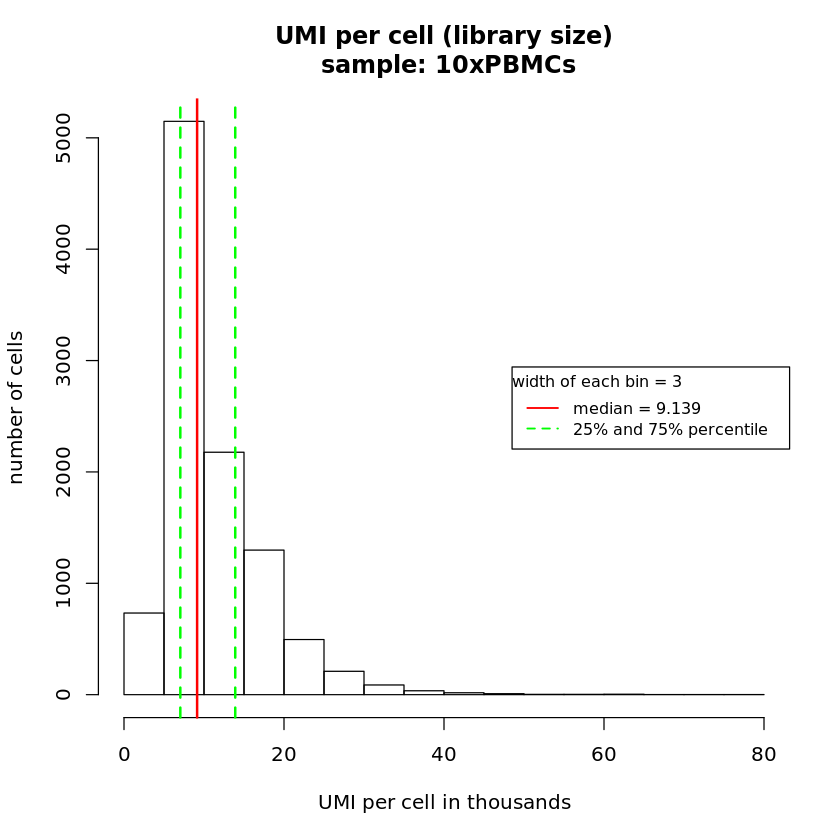

In [16]:
lib_size_mad=mad(umi_per_cell)
a=c(seq(0,max(umi_per_cell/1000),by=3)[1:length(seq(0,max(umi_per_cell/1000),by=3))-1],max(umi_per_cell/1000))
options(warn=-1)
hist(umi_per_cell/1000,freq=T,
     main=paste("UMI per cell (library size)\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("UMI per cell in thousands"))
abline(v=median(umi_per_cell/1000),col="red",lwd=2)
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
#abline(v=(median(umi_per_cell)+5*(mad(umi_per_cell)))/1000,col="blue",lty=2,lwd=2)
legend("right", legend=c(paste0("median = ",median(umi_per_cell/1000)), "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 3",title.adj=0)

jpeg(paste0(out,sample_ID,"_LIBRARY_SIZE.jpeg"))
hist(umi_per_cell/1000,breaks=a,freq=T,
     main=paste("UMI per cell (library size)\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("UMI per cell in thousands"))
abline(v=median(umi_per_cell/1000),col="red",lwd=2)
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
#abline(v=(median(umi_per_cell)+5*(mad(umi_per_cell)))/1000,col="blue",lty=2,lwd=2)
legend("right", legend=c(paste0("median = ",median(umi_per_cell/1000)), "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 3",title.adj=0)

dev.off()

### Genes per cell

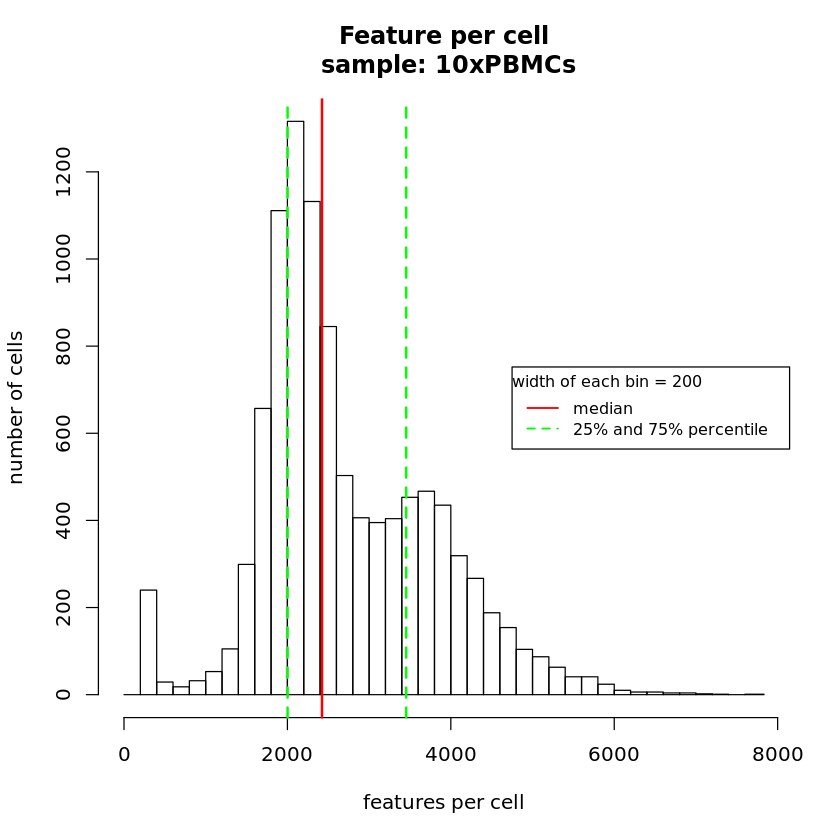

In [17]:
feature_per_cell=apply(assay(sce1),2,function(x)table(x %in% c(0))[1])
a=c(seq(0,max(feature_per_cell),by=200)[1:length(seq(0,max(feature_per_cell),by=200))-1],max(feature_per_cell))
hist(feature_per_cell,breaks=a,freq=T,
     main=paste("Feature per cell\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("features per cell"))
abline(v=median(feature_per_cell),col="red",lwd=2)
abline(v=quantile(feature_per_cell,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(feature_per_cell,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
legend("right", legend=c("median", "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 200",title.adj=0)

## saturation plot  
>should get flat at the right end  
>if it looks linear --  coverage is too low

png 
  2

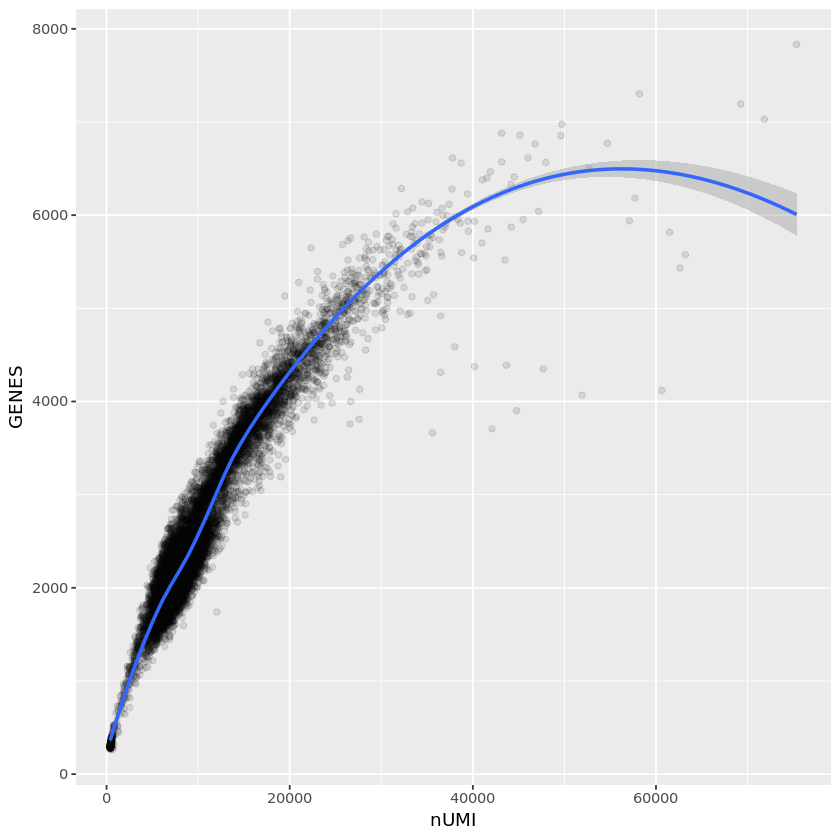

In [18]:
overview["UMI_per_cell",2]=mean(umi_per_cell)
overview["genes_per_cell",2]=mean(feature_per_cell)
sat=as.data.frame(cbind(feature_per_cell,umi_per_cell))
sat=sat[order(sat$feature_per_cell),]
colnames(sat)=c("GENES","nUMI")
p=ggplot(sat,aes(x=nUMI,y=GENES)) +
geom_point(alpha=0.1)+
stat_smooth(method=loess)
p
jpeg(paste0(out,sample_ID,"_saturation.jpeg"))
print(p)
dev.off()

### UMI per feature  
>* if you are combining several datasets I recomend to apply this threshold after you combined the individual datasets. 


png 
  2

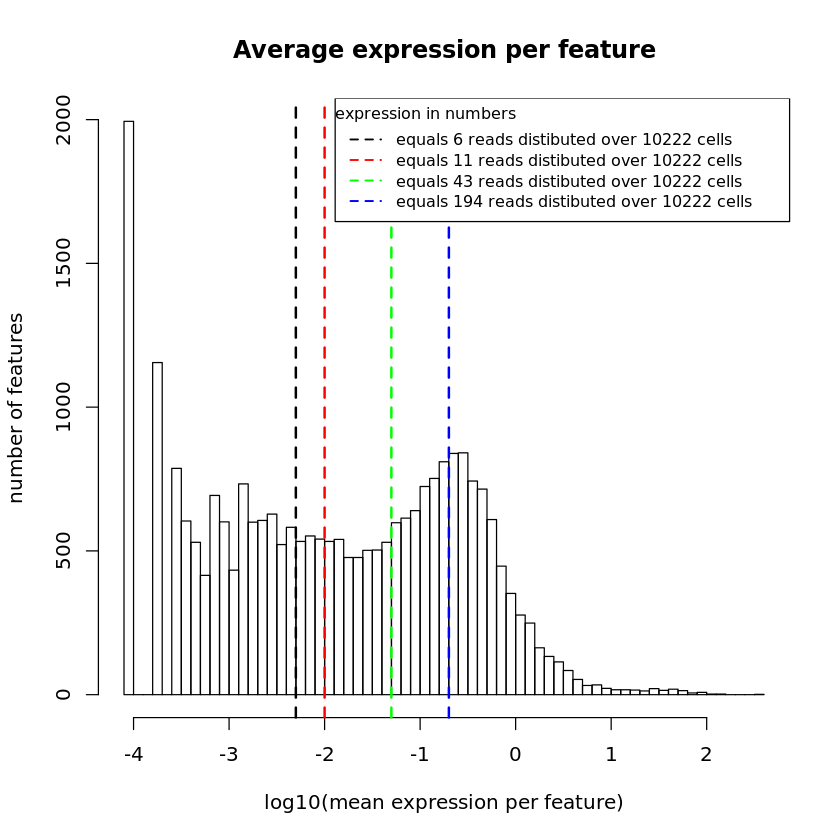

In [19]:
umi_per_feature=apply(assay(sce1),1,sum)
ave_per_feature=apply(assay(sce1),1,mean)
total=dim(sce1)[2]
one=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.2)]),digits=1)
two=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.05)]),digits=1)
drei=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.01)]),digits=1)
four=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.005)]),digits=1)

hist(log10(ave_per_feature),breaks=50,main=c("Average expression per feature"),xlab=c("log10(mean expression per feature)"),
     ylab=c("number of features"))
abline(v=log10(0.2),col="blue",lty=2,lwd=2)
abline(v=log10(0.05),col="green",lty=2,lwd=2)
abline(v=log10(0.01),col="red",lty=2,lwd=2)
abline(v=log10(0.005),col="black",lty=2,lwd=2)

legend("topright", legend=c(paste("equals",four,"reads distibuted over",total,"cells"), 
                            paste("equals",drei,"reads distibuted over",total,"cells"),
                            paste("equals",two,"reads distibuted over",total,"cells"),
                            paste("equals",one,"reads distibuted over",total,"cells")),
       col=c("black", "red","green","blue"), lty=c(2),lwd=1.5, cex=0.8, title="expression in numbers",title.adj=0)

jpeg(paste0(out,sample_ID,"_UMI_per_feature.jpeg"))
hist(log10(ave_per_feature),breaks=50,main=c("Average expression per feature"),xlab=c("log10(mean expression per feature)"),
     ylab=c("number of features"))
abline(v=log10(0.2),col="blue",lty=2,lwd=2)
abline(v=log10(0.05),col="green",lty=2,lwd=2)
abline(v=log10(0.01),col="red",lty=2,lwd=2)
abline(v=log10(0.005),col="black",lty=2,lwd=2)

legend("topright", legend=c(paste("equals",four,"reads distibuted over",total,"cells"), 
                            paste("equals",drei,"reads distibuted over",total,"cells"),
                            paste("equals",two,"reads distibuted over",total,"cells"),
                            paste("equals",one,"reads distibuted over",total,"cells")),
       col=c("black", "red","green","blue"), lty=c(2),lwd=1.5, cex=0.8, title="expression in numbers",title.adj=0)

dev.off()

In [20]:
## in case dataset is combined only remove gene with 0 entries
thresh1=c(0)
paste("applying a threshold of",thresh1, "UMI per gene will remove",table(umi_per_feature>thresh1)[1], "genes",sep=" ")
paste(" and leave",table(umi_per_feature>thresh1)[2],"in our analysis",sep=" ")
overview["genes_post_QC",2]=table(umi_per_feature>thresh1)[2]
sce2=sce1[umi_per_feature>thresh1,] 
dim(sce2)

[1] "applying a threshold of 0 UMI per gene will remove 10534 genes"

[1] " and leave 26067 in our analysis"

[1] 26067 10222

In [23]:
## in case several datasets are combined this can be run after you merged all datasets together
thresh1=c(100)
paste("applying a threshold of",thresh1, "UMI per gene will remove",table(umi_per_feature>thresh1)[1], "genes",sep=" ")
paste(" and leave",table(umi_per_feature>thresh1)[2],"in our analysis",sep=" ")
overview["genes_post_QC",2]=table(umi_per_feature>thresh1)[2]
sce2=sce1[umi_per_feature>thresh1,] 
dim(sce2)

[1] "applying a threshold of 100 UMI per gene will remove 23002 genes"

[1] " and leave 13599 in our analysis"

[1] 13599 10222

### I usually restrict to cells with at least 1000 UMIs  
>* if this steps excludes too many cells in your dataset you might rethink your coverage (re-sequence?)

In [24]:
umi_per_cell=apply(assay(sce2),2,sum)
sce3=sce2[,umi_per_cell >999] 
dim(sce3)

[1] 13599  9957

In [25]:
## -------------    UMIs in top 50 genes:
umi_per_feature=as.data.frame(apply(assay(sce3),1,sum))
sorted=umi_per_feature[order(umi_per_feature[,1],decreasing = TRUE),]
UMIs_in_top50 = (sum(sorted[1:50])/sum(sorted))*100
paste(format(UMIs_in_top50,digits=1)," percent of all reads are from the top50 genes in the dataset",sep=" ")
overview["UMIs_in_top50_in_perc",2] = UMIs_in_top50

[1] "32  percent of all reads are from the top50 genes in the dataset"

In [26]:
doublet_score=scran::doubletCells(sce3, k = 50,force.match=TRUE)  ## recalculate doublet score to write into metadata
doub_score=log10(doublet_score+1)
mat=assay(sce3)
dat=CreateSeuratObject(mat,assay = "RNA")
dat@meta.data$doub_score=doub_score
dat[["percent.mt"]] = PercentageFeatureSet(dat, pattern = "^MT-")
overview["cells_post_QC",2]=dim(dat)[2]
write.csv(overview,file=paste0(out,sample_ID,".csv"))  

## SEURAT SCT standard integration and clustering  

### regress out expression influenced by cell cycle  
>* the idea is to [calculate cell cycle phase scores](https://satijalab.org/seurat/archive/v3.1/cell_cycle_vignette.html) based on canonical markers, and then regress these out of the data during pre-processing  
>* scores for each cell are stored in meta data. 
>* we will be regressing out the difference between the G2M and S phase scores  
>* this way signals separating non-cycling cells and cycling cells will be maintained, but differences in cell cycle phase amongst proliferating cells (which are often uninteresting), will be regressed out of the data  

In [27]:
## this initial round is done just to calculate cell cycle scores
dat1=SCTransform(dat, variable.features.n = NULL,conserve.memory = F, return.only.var.genes = F)
s.genes = cc.genes$s.genes   ## these lists are loaded with Seurat
g2m.genes = cc.genes$g2m.genes
dat1 =CellCycleScoring(dat1, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
dat1$CC.Difference = dat1$S.Score - dat1$G2M.Score

Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 13599 by 9957

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 9957 cells



  |======================================================================| 100%


Found 4 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13599 genes



  |======================================================================| 100%


Computing corrected count matrix for 13599 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.901565 mins

Determine variable features

Set 6797 variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



In [28]:
head(dat1@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CC.Difference
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
AAACCCAGTATCGTAC-1,SeuratProject,1624,745,0.4310345,36334,5763,-0.13761195,-0.04112651,G1,SeuratProject,-0.096485445
AAACCCAGTCGGTGAA-1,SeuratProject,6575,1853,10.3269962,8158,2621,0.01040019,-0.02503658,S,SeuratProject,0.035436768
AAACCCAGTTAGAAAC-1,SeuratProject,17285,3778,5.5018802,39813,2491,-0.04924820,-0.05355588,G1,SeuratProject,0.004307687
AAACCCAGTTATCTTC-1,SeuratProject,3507,1498,13.5728543,15106,4669,-0.11040068,-0.01037463,G1,SeuratProject,-0.100026055
AAACCCAGTTGCCGAC-1,SeuratProject,6216,2098,6.0649936,8680,3042,-0.03181604,0.07487735,G2M,SeuratProject,-0.106693396
AAACCCAGTTTCCCAC-1,SeuratProject,21994,4549,6.5426935,84565,2626,0.01248555,-0.10532314,S,SeuratProject,0.117808686


In [29]:
dat1=SCTransform(dat1, variable.features.n = NULL,vars.to.regress=c("nCount_RNA","percent.mt","CC.Difference"),
            conserve.memory = F, return.only.var.genes = F) %>% RunPCA(verbose = TRUE)


Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 13599 by 9957

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 9957 cells



  |======================================================================| 100%


Found 4 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13599 genes



  |======================================================================| 100%


Computing corrected count matrix for 13599 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.877936 mins

Determine variable features

Set 6797 variable features

Place corrected count matrix in counts slot

Regressing out nCount_RNA, percent.mt, CC.Difference

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  NLRP1, CCPG1, SARS, OXR1, ZBTB7A, SKIL, ATG16L2, GID8, BFAR, RPL39 
	   PPP1CC, ORAI1, PIK3AP1, MTSS1, RAB5A, TBXAS1, IL4R, GINM1, SRSF6, TMBIM1 
	   RTF1, NR3C1, AP2A1, TMEM154, DYNLRB1, CANT1, ITSN2, CCNG1, FDFT1, CCNDBP1 
Negative:  EIF1, PAXX, RNF130, ARL2, CD8A, CD2, PHPT1, IDH2, EIF2AK2, MRPS33 
	   C1QC, SRGN, ETNK1, PYHIN1, DHPS, PLAAT3, LARP4, CERK, TAF10, ARF5 
	   TMEM126B, LST1, FCGRT, PRKACB, TMED2, NUCB1, CUX2, CWF19L2, UBXN4, CXCR3 
PC_ 2 
Positive:  MZT2A, RPS14, FAM89B, TSR3, APPBP2, FAM204A, DBR1, PSMD13, ARPP19, KANSL1 
	   PARP9, SNHG7, SCIMP, ATXN7, RLF, RPL37A, CCND3, MX1, DEPTOR, AL353743.2 
	   TRBC2, HSD17B1, NOSIP, UBE2S, TMUB2, ARFIP1, CAMK1, CCNE2, SSBP4, TNF

In [ ]:
## for the current PCA 6797 genes were used
length(dat1@assays$SCT@var.features)

In [4]:
load("QC_ok_10x_REF_PBMC.RData")

### construct nearest neighbor graph and run UMAP

### visualize cell cycle score

### inspect individual markers

> ### convert to NCBI SYMBOL 


In [43]:
w.dir=getwd()   
file.exists(paste0(w.dir,"/Homo_sapiens.gene_info"))  ## we need this for the conversion to work

[1] TRUE

In [ ]:
## this will require some work as we need to get back to featrues dataframe and subset this on accordingly
## this is due to a Seurat - bug currently not working
g.names=limma::alias2SymbolUsingNCBI(as.character(rownames(sce.seurat1)),
                                     paste0(w.dir,"/Homo_sapiens.gene_info"),required.columns = c("GeneID","Symbol"))
g.comb=as.data.frame(cbind(g.names,as.character(rownames(sce.seurat1))))
colnames(g.comb)[3]=c("rowN")
g.comb$new = ifelse(is.na(g.comb$Symbol), as.character(g.comb$rowN), g.comb$Symbol)
rownames(sce.seurat1)= as.character(g.comb$new)

### perform clustering of the data

### inspect some markers